In [152]:
import astropy.constants as const
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from plotting import label_axes

In [153]:
from utils import GeV_over_c

# Particle acceleration at planar shock with a free escape surface

The equation we're solving is a stationary advection-diffusion equation:

$$
u \frac{\partial f}{\partial z}
- \frac 1 3 \frac{du}{dz} p \frac{\partial f}{\partial p}
= \frac{\partial}{\partial z} \left[ D \frac{\partial f}{\partial z} \right]
+ Q
$$

Here:
- $f(z, p)$ is an isotropic part of the full phase-space distribution function, $f = \frac{dN}{dz dp}$
- $u$ is a plasma velocity field; in a shock reference frame we write
  $u = \begin{cases} -V \quad & z >0 \\ -V/r  &z<0 \end{cases}$,
  where $V$, shock velocity and $r$, it's compression ratio, are assumed to be known
  - consequently, we write $\frac{\partial u}{\partial z} = - V \frac{r - 1}{r} \delta(z)$
- $D$ is a diffusion coefficient, constant up- ($z>0$) and downstream ($z<0$) and equal to $D_u$ and $D_d$ respectively
- $Q$ is an injection term, phenomenologically modelling the process of initial spontaneous acceleration of particles
  from the thermal distribution tail to some initial momentum $p_i$, $Q \propto \delta(p - p_i) \delta(z)$

Boundary condition:
- $f(z_0, p) = 0$ - free streaming at some distance $z_0 > 0$ (in upstream)

## Basic geometry and shock properties

In [154]:
r = 4  # compression factor
alpha = 3 * r / (r - 1)
V = 1e-4 * const.c
z0_example = 10 * u.pc

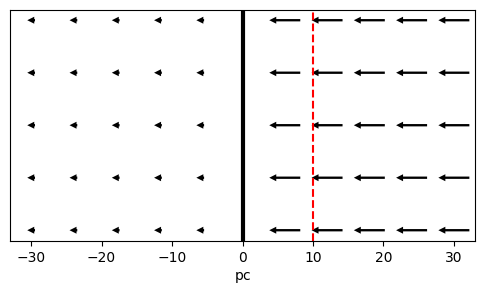

In [155]:
_, ax_z = plt.subplots(figsize=(6, 3))
ax_z: plt.Axes

quiver_scale = 15  # arbitrary!
quiver_kw = {"pivot": "middle", "width": 5e-3, "headlength": 3, "headaxislength": 3}

nz0 = 3
n_side = 5
upstream_grid_z = np.linspace(0, nz0 * z0_example, n_side + 1)[1:]
grid_perp = np.linspace(-5, 5, n_side)
ax_z.quiver(
    upstream_grid_z,
    grid_perp,
    *np.meshgrid(
        (-np.ones_like(upstream_grid_z)).value,
        np.zeros_like(grid_perp),
    ),
    scale=quiver_scale,
    **quiver_kw,
)

downstream_grid_z = np.linspace(-nz0 * z0_example, 0, n_side + 1)[:-1]
ax_z.quiver(
    downstream_grid_z,
    grid_perp,
    *np.meshgrid(
        (-np.ones_like(upstream_grid_z)).value,
        np.zeros_like(grid_perp),
    ),
    scale=quiver_scale * r,
    **quiver_kw,
)

ax_z.axvline(0, linewidth=3, color="k")
ax_z.axvline(z0_example, linestyle="--", color="r")
ax_z.set_yticks([])
plt.show()

## Acceleration conditions

We use example value of $Q_0 = 1~\mathrm{s^{-1} \; A.U.^{-2} \; GeV/c^{-2}}$ and injection momentum corresponding
to an upper tail ($10 k_B T$) of Maxwell distribution for $T = 10^{6}~\mathrm{K}$, corresponding
to a hot plasma.

For $D_u$ we use a value of $10^{27}~\mathrm{cm^2 / sec}$ – one order of magnitude smaller than the Galactic average.

In [156]:
def E_to_p(T: u.Quantity[u.eV]) -> u.Quantity[GeV_over_c]:
    gamma = 1 + (T / (const.m_p * const.c**2)).decompose()
    v = const.c * np.sqrt(1 - gamma**-2)
    return (gamma * const.m_p * v).to(GeV_over_c)


In [157]:
# injection at the shock
Q0 = 1 / (u.s * u.au**2 * GeV_over_c**2)

T_SNR = 1e6 * u.K
E_inj = 10 * const.k_B * T_SNR
p_inj = E_to_p(E_inj)
print(f"injection of protons at kin. energy T = {E_inj.to(u.eV):.2e} (momentum p = {p_inj:.2e}")

injection of protons at kin. energy T = 8.62e+02 eV (momentum p = 1.27e-03 GeV/c


In [158]:
delta = 1 / 3
D0 = 1e27 * u.cm**2 / u.s
p0 = E_to_p(100 * u.GeV)
D = lambda p: D0 * (p / p0) ** delta

l0 = D0 / V
l_p = lambda p: (D(p) / V).to(u.pc)

## Limiting case $z_0 \to \infty$

Simple analytical solution exists:

$$
f(z, p) = n_0 \left( \frac{p}{p_i} \right)^{-\alpha}
\begin{cases}
e^{-z / l(p)} \quad & z>0 \\ 
1 \quad & z \le 0 \\ 
\end{cases}
$$

Here $\alpha \equiv \frac{3r}{r - 1}$ – spectral index ($4$ for strong shock), $l(p) \equiv \frac{D_u(p)}{V}$ – diffusion length in the upstream.
$n_0 = \frac{\alpha Q_0}{V p_i}$ – spectrum normalization.

In [159]:
F_UNIT = 1 / (u.pc**3 * GeV_over_c**3)

def f_limit(p: u.Quantity[GeV_over_c], z: u.Quantity[u.pc]) -> u.Quantity[F_UNIT]:
    n0 = alpha * Q0 / (V * p_inj)
    return (n0 * (p / p_inj) ** (-alpha) * np.exp(-np.maximum(z, 0) / l_p(p))).to(F_UNIT)


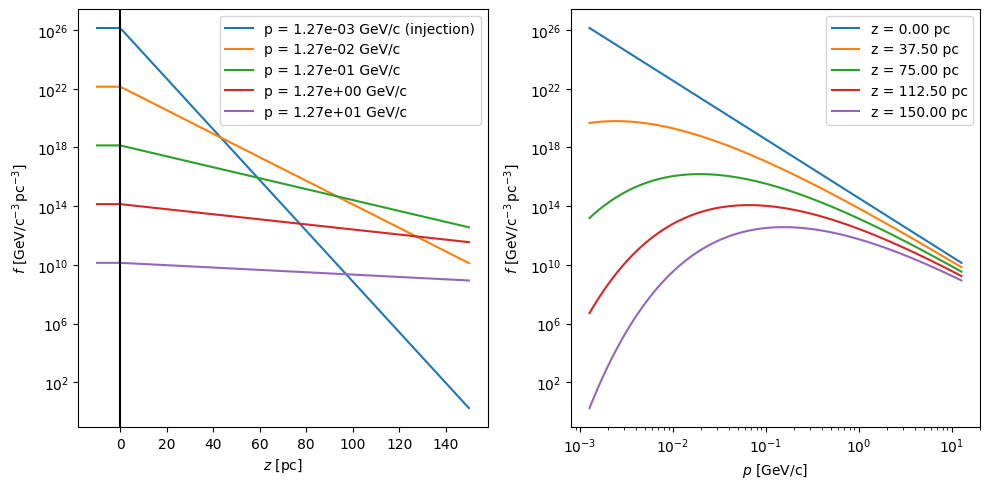

In [160]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax_z = axes[0]
ax_p = axes[1]

log10pinj = np.log10(p_inj.to(GeV_over_c).value)

z_grid = np.linspace(-1 * z0_example, 15 * z0_example, 100)
p_grid = np.logspace(log10pinj, 4 + log10pinj, 5) * GeV_over_c
for idx, pp in enumerate(p_grid):
    label = f"p = {pp:.2e}"
    if idx == 0:
        label = label + " (injection)"
    ax_z.plot(z_grid, f_limit(pp, z_grid), label=label)
ax_z.set_yscale("log")
ax_z.axvline(0, color="k")
label_axes(ax_z, "z", "f")
ax_z.legend()

z_grid = np.linspace(0, 15 * z0_example, 5)
p_grid = np.logspace(log10pinj, 4 + log10pinj, 100) * GeV_over_c
for z in z_grid:
    ax_p.loglog(p_grid, f_limit(p_grid, z), label=f"z = {z:.2f}")
label_axes(ax_p, "p", "f")
ax_p.legend()

plt.tight_layout()
plt.show()

## General case

As before, the solution is separable in terms of $p$ and $z$. The latter is trivial:

$$
f(z, p) = f_0(p) \begin{cases}
\frac{ e^{-z / l(p)} - e^{-z_0 / l(p)} }{ 1 - e^{-z_0 / l(p)}} \quad & z > 0 \\
1 \quad & z \le 0
\end{cases}
$$

Substituting this form into the original PDE and integrating it across $z=0$,
we get the following equation for $f_0(p)$:

$$
p V \frac{r - 1}{3r} \frac{\partial f_0}{\partial p}
= - f_0(p) \frac{D}{l(p)} \frac{1}{ (1 - e^{-z_0 / l(p)})} + Q_0 \delta(p - p_i)
$$

For $p > p_i$ this transforms into

$$
\frac{df_0}{dp} = f_0 \frac{ - \frac{\alpha}{p} }{1 - e^{-z_0 / l(p)}}
$$

... which gives

$$
f_0 = f_0(p_i) \exp \left[ \int_{p_i}^{p} dp' \frac{ - \alpha / p' }{1 - e^{-z_0 / l(p')}} \right]
$$

Approximate solution is a power-law with an exponential cutoff at $p$ corresponding to $l(p_cut) = z_0$:
$p_{cut} = p_0 \left( z_0 / l_0 \right)^{1/\delta}$

$$
f_0(p) = f_0(p_i) \begin{cases}

\left( \frac{p}{p_{inj}} \right)^{-\alpha} \quad & p \le p_{cut} \\

\left( \frac{p_{cut}}{p_{inj}} \right)^{-\alpha}
\exp \left( - \frac{\alpha}{\delta} \left( \frac{l(p)}{z_0} - 1\right) \right)

\quad & p > p_{cut} \\
\end{cases}
$$

In [169]:
def f_0_shape_approx(
    p: u.Quantity[GeV_over_c], z0: u.Quantity[u.pc]
) -> u.Quantity[F_UNIT]:
    # this n0 is wrong! we use it only for ease of comparison w/ limit case
    p_cutoff = p0 * (z0 / l0) ** (1 / delta)
    res = (np.minimum(p, p_cutoff) / p_inj) ** (-alpha)
    above_cut = p > p_cutoff
    res[above_cut] *= np.exp(-(alpha / delta) * (l_p(p[above_cut]) / z0 - 1))
    return res

    

def f_approx(
    p: u.Quantity[GeV_over_c], z: u.Quantity[u.pc], z0: u.Quantity[u.pc]
) -> u.Quantity[F_UNIT]:
    # this n0 is wrong! we use it only for ease of comparison w/ limit case
    f_0_norm = alpha * Q0 / (V * p_inj)
    f_0 = f_0_norm * f_0_shape_approx(p, z0)
    return (
        f_0
        * (np.exp(-np.maximum(z, 0) / l_p(p)) - np.exp(-z0 / l_p(p)))
        / (1 - np.exp(-z0 / l_p(p)))
    ).to(F_UNIT)

In [170]:
import scipy.integrate


def f_0_shape_numint(p: u.Quantity[GeV_over_c], z0: u.Quantity[u.pc]) -> float:
    def integrand(log_pp: float, z0: u.Quantity[u.pc]) -> float:
        pp = np.exp(log_pp) * GeV_over_c
        jacobian = pp
        return jacobian * (-alpha / pp) / (1 - np.exp(-(z0 / l_p(pp)).decompose()))

    integral, *_ = scipy.integrate.quad(
        integrand,
        a=np.log(p_inj.to(GeV_over_c).value),
        b=np.log(p.to(GeV_over_c).value),
        args=(z0,),
    )
    return np.exp(integral)


def f_numint(
    p: u.Quantity[GeV_over_c], z: u.Quantity[u.pc], z0: u.Quantity[u.pc]
) -> u.Quantity[F_UNIT]:
    # this n0 is wrong! we use it only for ease of comparison w/ limit case
    f_0_norm = alpha * Q0 / (V * p_inj)
    f_0 = f_0_norm * f_0_shape_numint(p, z0)
    return (
        f_0
        * (np.exp(-np.maximum(z, 0) / l_p(p)) - np.exp(-z0 / l_p(p)))
        / (1 - np.exp(-z0 / l_p(p)))
    ).to(F_UNIT)

### Spectral shape

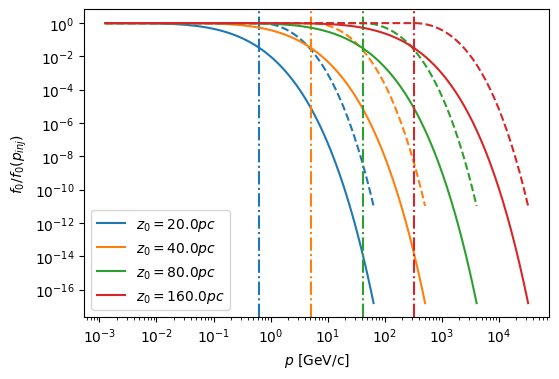

In [171]:
_, ax = plt.subplots(figsize=(6, 4))

for z0 in [20 * u.pc, 40 * u.pc, 80 * u.pc, 160 * u.pc]:
    l0 = D0 / V
    p_cutoff = p0 * (z0 / l0) ** (1 / delta)
    p_grid = (
        np.logspace(log10pinj, 2 + np.log10(p_cutoff.to(GeV_over_c).value), 100)
        * GeV_over_c
    )
    power_law = (p_grid / p_inj)**(-4)
    line, *_ = ax.loglog(
        p_grid,
        np.array([f_0_shape_numint(p, z0=z0) for p in p_grid]) / power_law,
        label=f"$z_0 = {z0}$",
    )
    ax.loglog(
        p_grid,
        f_0_shape_approx(p_grid, z0) / power_law,
        color=line.get_color(),
        linestyle="--",
    )
    ax.axvline(p_cutoff, color=line.get_color(), linestyle="-.")

label_axes(ax, "p", "f_0 / f_0(p_{inj})")
ax.legend()
plt.show()

fit results: [1.00054659 0.21180589] +/- [[ 6.07045135e-04 -3.47153261e-05]
 [-3.47153261e-05  1.94989802e-05]]


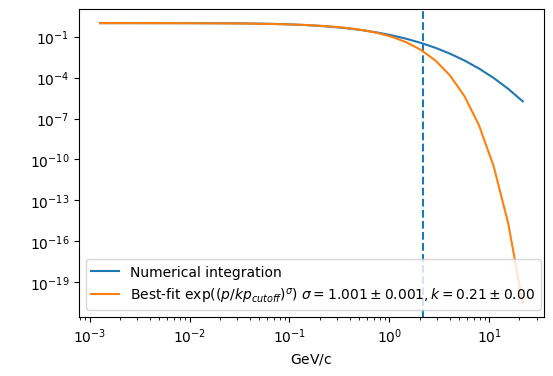

In [172]:
import scipy.optimize


fig, ax = plt.subplots(figsize=(6, 4))

z0_fit = 30 * u.pc
p_cutoff = p0 * (z0_fit / l0) ** (1 / delta)

p_grid = (
    np.logspace(log10pinj, 1 + np.log10(p_cutoff.to(GeV_over_c).value), 30)
    * GeV_over_c
)
power_law = (p_grid / p_inj).decompose().value ** (-4)
cutoff_shape = np.array([f_0_shape_numint(p, z0=z0_fit) for p in p_grid]) / power_law
line, *_ = ax.loglog(p_grid, cutoff_shape, label="Numerical integration")
ax.axvline(p_cutoff, color=line.get_color(), linestyle="--")


def cutoff(p: float | u.Quantity, sigma: float, mult: float):
    if not isinstance(p, u.Quantity):
        p = p * GeV_over_c
    return np.exp(-((p / (mult * p_cutoff)) ** sigma))


# for sigma in (2.0, 1.5, 1.0):
#     ax.loglog(p_grid, cutoff(p_grid, sigma, 1.0), label=f"$ \\sigma = {sigma} $")

popt, pcov = scipy.optimize.curve_fit(
    f=cutoff,
    xdata=p_grid.to(GeV_over_c).value,
    ydata=cutoff_shape,
    p0=(1.0, 1.0),
    bounds=([0.0, 0.0], [5.0, 10.0]),
)
print(f"fit results: {popt} +/- {pcov}")
sigma_co = popt[0]
sigma_co_err = pcov[0][0]
mult = popt[1]
mult_err = pcov[1][1]

approxline, *_ = ax.loglog(
    p_grid,
    cutoff(p_grid, sigma_co, mult),
    label=f"Best-fit $ \\exp( (p / kp_{{cutoff}})^\\sigma ) $ $ \\sigma = {sigma_co:.3f} \\pm {sigma_co_err:.3f}, k = {mult:.2f} \\pm {mult_err:.2f} $",
)

ax.legend()
# label_axes(ax, "p", "f_0 / f_0(p_{inj})")
plt.show()

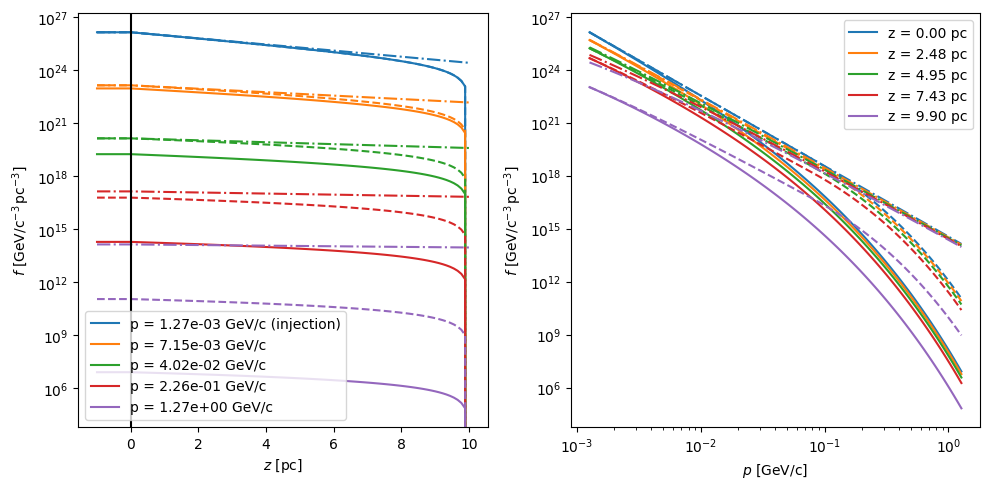

In [173]:
_, axes = plt.subplots(ncols=2, figsize=(10, 5))
ax_z = axes[0]
ax_p = axes[1]

log10pinj = np.log10(p_inj.to(GeV_over_c).value)

z_grid = np.linspace(-0.1 * z0_example, z0_example, 100)
p_grid = np.logspace(log10pinj, 3 + log10pinj, 5) * GeV_over_c
for idx, p in enumerate(p_grid):
    label = f"p = {p:.2e}"
    if idx == 0:
        label = label + " (injection)"
    line, *_ = ax_z.plot(z_grid, f_numint(p, z_grid, z0=z0_example), label=label)
    ax_z.plot(
        z_grid,
        f_approx(p, z_grid, z0=z0_example),
        color=line.get_color(),
        linestyle="--",
    )
    ax_z.plot(z_grid, f_limit(p, z_grid), color=line.get_color(), linestyle="-.")
ax_z.set_yscale("log")
ax_z.axvline(0, color="k")
label_axes(ax_z, "z", "f")
ax_z.legend()

z_grid = np.linspace(0, 0.99 * z0_example, 5)
p_grid = np.logspace(log10pinj, 3 + log10pinj, 100) * GeV_over_c
for z in z_grid:
    label = f"z = {z:.2f}"
    line, *_ = ax_p.loglog(
        p_grid, u.Quantity([f_numint(p, z, z0=z0_example) for p in p_grid]), label=label
    )
    ax_p.loglog(p_grid, f_approx(p_grid, z, z0=z0_example), color=line.get_color(), linestyle="--")
    ax_p.loglog(p_grid, f_limit(p_grid, z), color=line.get_color(), linestyle="-.")
label_axes(ax_p, "p", "f")
ax_p.legend()

plt.tight_layout()
plt.show()